### Data Dictionary

**Beetles table**
* ID: beetle ID (unique integer)
* Group: flight test group (A, B, C, D)
* Sex: M, F
* date_treated
* date_dead
* OrNV detected: t, f
* Notes

**Observations table**

This table is not in standard format. It is a matrix with 'ID' as the first column.
The remaining columns labeled '2023/02/28', '2023/03/01', ... contain observation codes for each beetle.
The dates indicate when the observation was made. 
For example, an F in column 2023/02/28 indicates that this beetle flew during the previous night ( 2023-02-27 19:00 to 2023-02-28 07:00. 

* F: beetle flew (collected from bottom of chamber)
* N: beetle did not fly (collected from paint bucket)
* D: dead
* M: missing

In [30]:
import pandas as pd
import plotly.express as px

# GET DATA

In [31]:
SHEET_ID = '1jwgm7h_-Al4MspsfC4sP6E03QrjpZcTPr2JC7WLU2QM'

In [32]:
def get_google_sheet(sheet_id, sheet_name):
    """
    Returns a data frame generated from a Google sheet
    """
    url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
    return pd.read_csv(url)

# SHEET_ID = '1jwgm7h_-Al4MspsfC4sP6E03QrjpZcTPr2JC7WLU2QM'
# get_google_sheet(SHEET_ID, 'Beetles')

In [33]:
# get mass table

try:
    df_mass = get_google_sheet(SHEET_ID, 'Mass')
    df_mass = pd.melt(df_mass, id_vars=['Unnamed: 0'], var_name='date', value_name='milligrams')
    df_mass.rename({'Unnamed: 0':'ID'}, axis='columns', inplace=True)
    df_mass.dropna(inplace=True)    
    # save to disk
    df_mass.to_csv('mass.csv', index=False)
    print('Mass sheet downloaded and saved to mass.csv')
except Exception as e: 
    print(e)
    print('WARNING: Failed to get beetles table from Google sheets; Reading csv file from disk')
    df_beetles = pd.read_csv('mass.csv')
df_mass

Mass sheet downloaded and saved to mass.csv


,ID,date,milligrams
0,1,2023/03/13,2480.4
1,2,2023/03/13,2879.3
2,3,2023/03/13,5122.6
3,4,2023/03/13,3811.9
4,5,2023/03/13,5063.8
...,...,...,...
676,97,2023/04/04,4966.2
678,99,2023/04/04,3906.8
685,106,2023/04/04,4243.8
691,114,2023/04/04,3557.3


In [34]:
# get 'beetles' table

try:
    df_beetles = get_google_sheet(SHEET_ID, 'Beetles')    
    # remove columns after 'Notes'
    df_beetles = df_beetles.loc[:,:'Notes']
    # Convert dates from string to datetime
    df_beetles['date treated'] = pd.to_datetime(df_beetles['date treated'], format='%Y/%m/%d')
    df_beetles['date dead'] = pd.to_datetime(df_beetles['date dead'], format='%Y/%m/%d')
    # save to disk
    df_beetles.to_csv('beetles.csv', index=False)
    print('Beetles sheet downloaded and saved to beetles.csv')
except Exception as e: 
    print(e)
    print('WARNING: Failed to get beetles table from Google sheets; Reading csv file from disk')
    df_beetles = pd.read_csv('beetles.csv')
df_beetles

Beetles sheet downloaded and saved to beetles.csv


,ID,Group,Sex,date treated,date dead,OrNV detected,Notes
0,1,A,F,2023-03-06,NaT,NaN,NaN
1,2,A,M,2023-03-06,2023-03-27,NaN,NaN
2,3,A,F,2023-03-06,NaT,NaN,NaN
3,4,A,M,2023-03-06,2023-03-26,NaN,NaN
4,5,A,F,2023-03-06,NaT,NaN,NaN
...,...,...,...,...,...,...,...
110,111,D,M,2023-03-06,NaT,NaN,NaN
111,112,D,M,2023-03-06,2023-03-27,NaN,NaN
112,113,D,F,2023-03-06,2023-03-26,NaN,NaN
113,114,D,M,2023-03-06,NaT,NaN,NaN


In [35]:
# get observations table

try:
    df_observations = get_google_sheet(SHEET_ID, 'Observations')
    # No idea why the first column is unnamed, but this fixes the problem
    df_observations.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
    # Drop all columns which do not contain data
    df_observations.dropna(axis='columns', how='all', inplace=True)
    # Convert the table into a more standard format
    df_observations = df_observations.melt(id_vars='ID')
    # Rename
    df_observations.rename(columns={'variable':'date', 'value':'obs'}, inplace=True)
    # Convert date from string to datetime
    df_observations['date'] = pd.to_datetime(df_observations['date'], format='%Y/%m/%d')    
    df_observations.to_csv('observations.csv', index=False)
    print('Observations sheet downloaded and saved to observations.csv')
except Exception as e: 
    print(e)
    print('WARNING: Failed to get observations sheet from Google sheets; Reading csv file from disk')
    df_observations = pd.read_csv('observations.csv')
df_observations

time data "2023/03/02.1" at position 33 doesn't match format specified


,ID,date,obs
0,1,2023-02-28,N
1,2,2023-02-28,N
2,3,2023-02-28,N
3,4,2023-02-28,N
4,5,2023-02-28,N
...,...,...,...
3675,111,2023-03-31,N
3676,112,2023-03-31,NaN
3677,113,2023-03-31,NaN
3678,114,2023-03-31,N


In [36]:
df_observations.obs.unique()

array(['N', 'F', 'ND', '-', 'M', nan, '1', 'Found'], dtype=object)

In [37]:
# Merge tables using ID as key

df_merged = df_beetles.merge(df_observations)

# Drop all columns which do not contain data
df_merged.dropna(axis='columns', how='all', inplace=True)

# Select the rows we are interested in
# df_merged = df_merged.query('obs.str.contains("F") | obs.str.contains("N")')

df_merged

,ID,Group,Sex,date treated,date dead,Notes,date,obs
0,1,A,F,2023-03-06,NaT,NaN,2023-02-28,N
1,1,A,F,2023-03-06,NaT,NaN,2023-03-01,N
2,1,A,F,2023-03-06,NaT,NaN,2023-03-02,F
3,1,A,F,2023-03-06,NaT,NaN,2023-03-03,F
4,1,A,F,2023-03-06,NaT,NaN,2023-03-04,NaN
...,...,...,...,...,...,...,...,...
3675,115,D,F,2023-03-06,NaT,NaN,2023-03-27,N
3676,115,D,F,2023-03-06,NaT,NaN,2023-03-28,N
3677,115,D,F,2023-03-06,NaT,NaN,2023-03-29,N
3678,115,D,F,2023-03-06,NaT,NaN,2023-03-30,N


In [38]:
# Select rows where obs contains 'F' (flew) or 'N' (did not fly)
df_merged = df_merged.query("obs.str.contains('F') | obs.str.contains('N')")

# Create a new column 'flew'
df_merged['flew'] = df_merged.obs.str.contains('F')

df_merged

/tmp/ipykernel_11065/4139199302.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Group,Sex,date treated,date dead,Notes,date,obs,flew
0,1,A,F,2023-03-06,NaT,NaN,2023-02-28,N,False
1,1,A,F,2023-03-06,NaT,NaN,2023-03-01,N,False
2,1,A,F,2023-03-06,NaT,NaN,2023-03-02,F,True
3,1,A,F,2023-03-06,NaT,NaN,2023-03-03,F,True
5,1,A,F,2023-03-06,NaT,NaN,2023-03-05,N,False
...,...,...,...,...,...,...,...,...,...
3675,115,D,F,2023-03-06,NaT,NaN,2023-03-27,N,False
3676,115,D,F,2023-03-06,NaT,NaN,2023-03-28,N,False
3677,115,D,F,2023-03-06,NaT,NaN,2023-03-29,N,False
3678,115,D,F,2023-03-06,NaT,NaN,2023-03-30,N,False


In [39]:
# Create a new dataframe containing only the columns we need

df = df_merged[['Group','date','flew']]
df

,Group,date,flew
0,A,2023-02-28,False
1,A,2023-03-01,False
2,A,2023-03-02,True
3,A,2023-03-03,True
5,A,2023-03-05,False
...,...,...,...
3675,D,2023-03-27,False
3676,D,2023-03-28,False
3677,D,2023-03-29,False
3678,D,2023-03-30,False


In [40]:
def proportion_flew(df):
    """ returns proportion of beetles which flew """
    return df.flew.sum() / df.flew.count()

# proportion_flew(df)

In [41]:
# calculate proportion of beetles which flew for each 'Group' and 'date'
gb = df.groupby(['Group','date']).apply(proportion_flew)
gb

Group  date      
A      2023-02-28    0.035714
       2023-03-01    0.035714
       2023-03-02    1.000000
       2023-03-03    0.785714
       2023-03-05    0.107143
                       ...   
D      2023-03-27    0.000000
       2023-03-28    0.000000
       2023-03-29    0.000000
       2023-03-30    0.000000
       2023-03-31    0.000000
Length: 119, dtype: float64

In [42]:
pd.to_datetime('2023-03-06')

Timestamp('2023-03-06 00:00:00')

# PLOT

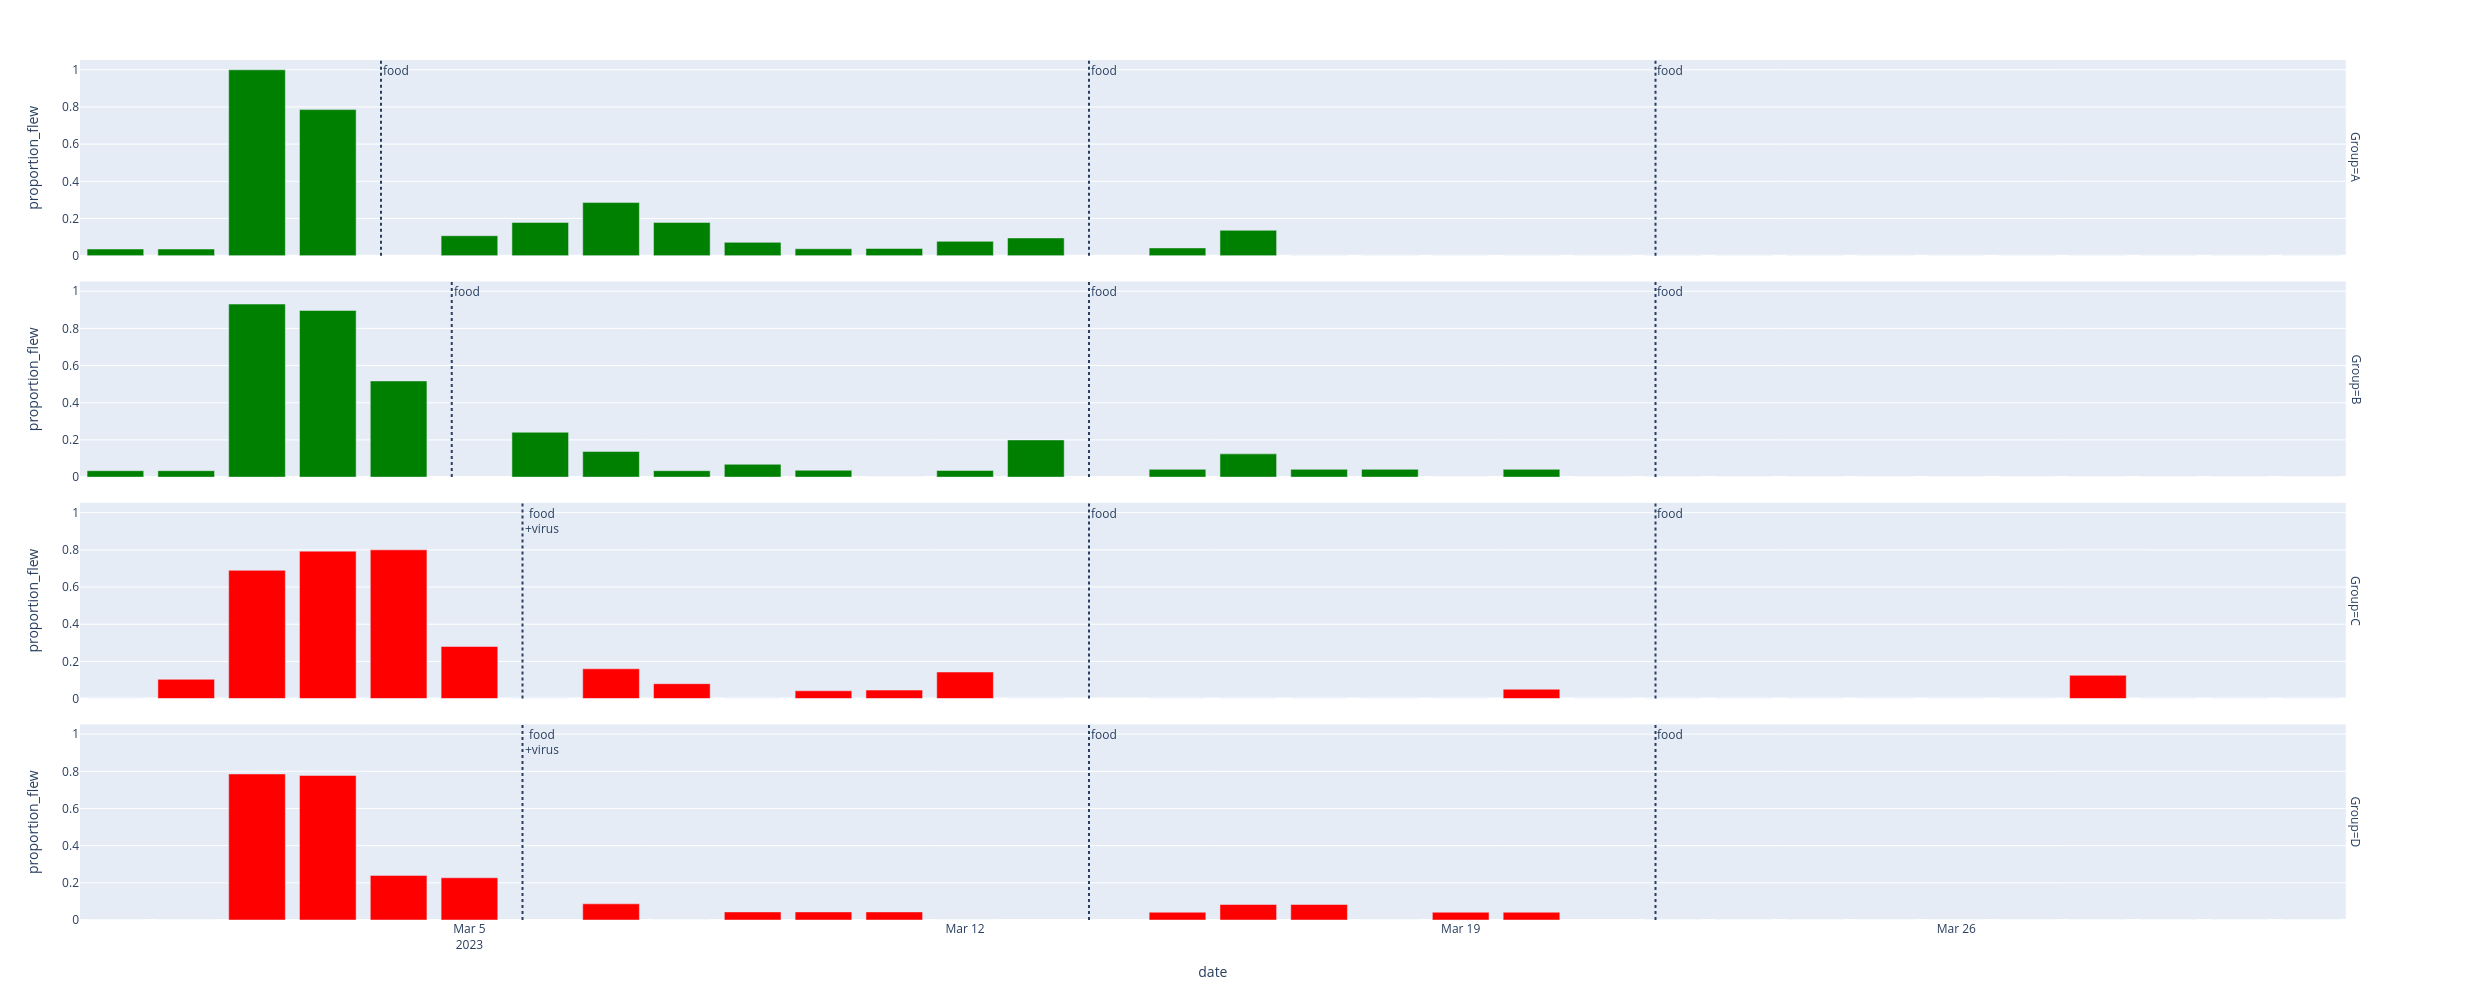

In [43]:
df = gb.reset_index().rename(columns={0:'proportion_flew'})
fig = px.bar(df, x='date', y='proportion_flew', facet_row='Group', color='Group', color_discrete_sequence=['green','green','red','red'])

fig.update_layout(showlegend=False, width=1000, height=1000)

fig.add_vline(x=pd.to_datetime('2023-03-05 08').timestamp()*1000, line_dash="dot", row=1, col=1, annotation_text="food<br>+virus", annotation_position="top right")
fig.add_vline(x=pd.to_datetime('2023-03-05 08').timestamp()*1000, line_dash="dot", row=2, col=1, annotation_text="food<br>+virus", annotation_position="top right")
fig.add_vline(x=pd.to_datetime('2023-03-04 08').timestamp()*1000, line_dash="dot", row=3, col=1, annotation_text="food", annotation_position="top right")
fig.add_vline(x=pd.to_datetime('2023-03-03 08').timestamp()*1000, line_dash="dot", row=4, col=1, annotation_text="food", annotation_position="top right")

fig.add_vline(x=pd.to_datetime('2023-03-13 08').timestamp()*1000, line_dash="dot", row="all", col=1, annotation_text="food", annotation_position="top right")
fig.add_vline(x=pd.to_datetime('2023-03-21 08').timestamp()*1000, line_dash="dot", row="all", col=1, annotation_text="food", annotation_position="top right")
   
fig.write_html("results-plot.html")
fig.write_image("results-plot.png")

fig.show()